# Using dowhy casual graph analysis

An example hypothesis (Crop Rotation Impact):
**Crop rotation frequency** has a positive (or negative) effect on **species abundance**, controlling for land use (LGN), object height (OHN) and greenness.

The goal is to prove/disprove the above hypothesis.

I am using dummy variable.

After creating the casual graph, we need to identify the casual effect, estimate it (numerical value) and refute it (i.e. validate the estimation)

In [5]:
# !pip install dowhy
# !pip install rasterio

In [1]:
import networkx as nx
import rasterio
import pandas as pd
import numpy as np
from dowhy import CausalModel

## Generate dummy variable

In [2]:
# Set a random seed for reproducibility
np.random.seed(42)

# Generate dummy data
n = 500  # Number of observations (grid cells)

data = pd.DataFrame({
    "longitude": np.random.uniform(4.5, 7.5, n),  # Longitude range in the Netherlands
    "latitude": np.random.uniform(51, 53.5, n),  # Latitude range in the Netherlands
    "crop_rotation_frequency": np.random.randint(0, 4, n),  # Crop rotations per year (0 to 3)
    "species_abundance": np.random.poisson(20, n),  # Species abundance as Poisson distribution
    "LGN": np.random.choice([0, 1], size=n, p=[0.7, 0.3]),  # Land use (binary categorical: 0 or 1)
    "greenness": np.random.uniform(0.2, 0.8, n),  # Greenness index (0.2 to 0.8)
})

# Save the dummy data for future use
dummy_data_path = "./dummy_data_for_causalml.csv"
data.to_csv(dummy_data_path, index=False)

In [3]:
# Load data
dummy_data_path = "./dummy_data_for_causalml.csv"
data = pd.read_csv(dummy_data_path)


# Define the causal graph structure
causal_graph = """
digraph {
    crop_rotation_frequency -> species_abundance;
    crop_rotation_frequency -> LGN;
    LGN -> species_abundance;
    crop_rotation_frequency -> greenness;
    greenness -> species_abundance;
}
"""

# Create causal model
model = CausalModel(
    data=data, # This is the preprocessed dataset
    treatment="crop_rotation_frequency",
    outcome="species_abundance",
    graph=causal_graph
)

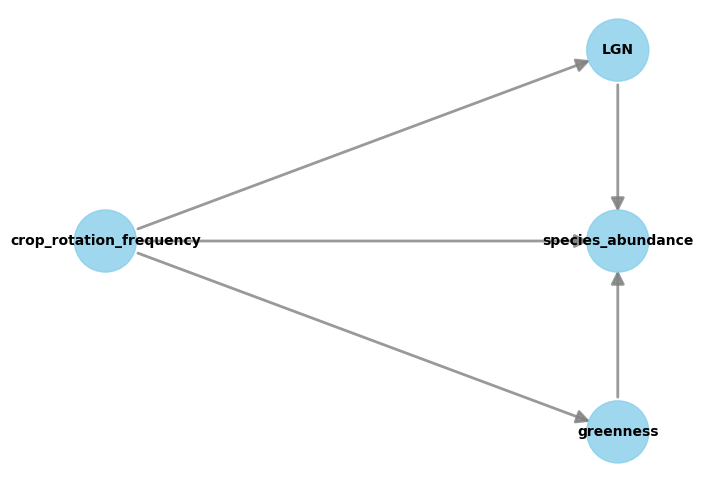

In [4]:
# Display the graph for verification
model.view_model()

### Identify casual effect
What does it mean?
- It ensures that the causal effect we want to estimate is valid under the assumptions of our graph.
- Provides a blueprint for how the effect can be estimated from our data.
- It is important for the next step which is estimating the effect

In [5]:
# Identify causal effect and return target estimands
identified_estimand = model.identify_effect()
print("Identified Estimand:")
print(identified_estimand)

Identified Estimand:
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                   
──────────────────────────(E[species_abundance])
d[crop_rotation_frequency]                      
Estimand assumption 1, Unconfoundedness: If U→{crop_rotation_frequency} and U→species_abundance then P(species_abundance|crop_rotation_frequency,,U) = P(species_abundance|crop_rotation_frequency,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



### Summary of the result:
**Causal Effect Type:**

The model is estimating the Average Treatment Effect (ATE), which is the expected change in species abundance caused by changing crop rotation frequency.

**Backdoor Criterion:**

The backdoor path is valid, meaning we can estimate the causal effect by adjusting for observed confounders (e.g., land use, object height, greennes).

**Assumes Unconfoundedness:**

There are no unobserved confounders influencing both crop rotation frequency and species abundance.

**Instrumental Variable (IV):**
No valid IV was found in our model. Therefore, IV methods are not applicable. IVs are special variables that affect the treatment but not the outcome directly (except through the treatment). Since I didn't specify an IV, this is expected.

**Frontdoor Criterion:**
No valid frontdoor paths were identified, indicating no mediators are present that could be used to estimate the causal effect.



# Estimate casual effect

This command computes the actual numerical value of the causal effect of the treatment on the outcome.

In [6]:
# Estimate the causal effect using linear regression
causal_estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)
print("\nCausal Estimate:")
print(causal_estimate)


Causal Estimate:
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
            d                                   
──────────────────────────(E[species_abundance])
d[crop_rotation_frequency]                      
Estimand assumption 1, Unconfoundedness: If U→{crop_rotation_frequency} and U→species_abundance then P(species_abundance|crop_rotation_frequency,,U) = P(species_abundance|crop_rotation_frequency,)

## Realized estimand
b: species_abundance~crop_rotation_frequency
Target units: ate

## Estimate
Mean value: 0.16202290076335757



/home/conda/fairicubeuc2/8fc1c67e5f7b5952694dae7800537a3e0447a5124c6539615256c5b132bd8d30-20241017-125710-520878-32-torch/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


## Key Takeaways from the result:
- The estimated causal effect indicates a positive relationship between crop_rotation_frequency and species_abundance.
- A higher frequency of crop rotation is associated with an increase in species abundance, on average.
- The validity of this result hinges on the unconfoundedness assumption being correct. If there are unmeasured confounders, the estimate may be biased.


## Refute estimate
This function evaluates the robustness of the estimated causal effect by applying a placebo test. This is part of the refutation tests provided by DoWhy to validate causal estimates.

In [7]:
# Refute the causal estimate
refutation = model.refute_estimate(
    identified_estimand, causal_estimate, method_name="placebo_treatment_refuter"
)
print("\nRefutation Result:")
print(refutation)

/home/conda/fairicubeuc2/8fc1c67e5f7b5952694dae7800537a3e0447a5124c6539615256c5b132bd8d30-20241017-125710-520878-32-torch/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/conda/fairicubeuc2/8fc1c67e5f7b5952694dae7800537a3e0447a5124c6539615256c5b132bd8d30-20241017-125710-520878-32-torch/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/conda/fairicubeuc2/8fc1c67e5f7b5


Refutation Result:
Refute: Use a Placebo Treatment
Estimated effect:0.16202290076335757
New effect:-0.028297241696111575
p value:0.82



/home/conda/fairicubeuc2/8fc1c67e5f7b5952694dae7800537a3e0447a5124c6539615256c5b132bd8d30-20241017-125710-520878-32-torch/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/conda/fairicubeuc2/8fc1c67e5f7b5952694dae7800537a3e0447a5124c6539615256c5b132bd8d30-20241017-125710-520878-32-torch/lib/python3.10/site-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/conda/fairicubeuc2/8fc1c67e5f7b5

**Result Details**

Refutation Result:
- Estimated effect:0.16202290076336467
- New effect:-0.03483991056847522
- p value:0.78


*Estimated Effect: 0.162*
This is the original causal estimate obtained from the model. It suggests that a one-unit increase in the treatment variable (crop_rotation_frequency) results in a 0.162-unit increase in species_abundance, on average.

*New Effect (Placebo Estimate):*
−0.0348
This is the causal effect estimated using the randomly generated placebo treatment variable. Ideally, this should be close to 0, as the placebo variable should have no causal relationship with the outcome.

*p-value:*
0.78
The p-value indicates the likelihood of observing the difference between the estimated effect and the placebo effect if the original estimate were valid.
A high p-value (typically above 0.05) suggests that the placebo effect is not significantly different from the original causal estimate. This weakens confidence in the robustness of the causal estimate.
